# eReefs dataset maps

We will now apply what we've learned to our eReefs dataset. 


:::{seealso}
Some examples of plotted maps from eReefs dataset can be found on the
[AIMS website](https://ereefs.aims.gov.au/ereefs-aims#ereefs-bgc-model).
:::

## Load the required Python libraries

First of all, load the necessary libraries. These are the ones we discussed previously:

+ numpy
+ matplotlib
+ cartopy

In [7]:
import os
import numpy as np

import datetime as dt

import netCDF4
from netCDF4 import Dataset, num2date

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config['data_dir'] = os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))

import cmocean

from matplotlib import pyplot as plt
# %config InlineBackend.figure_format = 'retina'
plt.ion()  # To trigger the interactive inline mode

## Define which data to be plotted.

:::{note}
We saw that via the OpenDAP protocol we can query eReefs dataset directly from source as NetCDF files. As you saw in the previous cell we have imported the Python `netcdf4` library which provide series of functions and commands to load these files on our Jupyter environment.  
:::

We define which data we want to read and plot.

- **inputFile**
  The netCDF input file. This can either be a downloaded file (see [How to manually download derived data from THREDDS](http://ereefs.aims.local/ereefs-aims/help/how-to-manually-download-derived-data)) or a  OPeNDAP URL from the [AIMS THREDDS server](http://thredds.ereefs.aims.gov.au/thredds/catalog.html). For this tutorial we are using the OPeNDAP URL.
- **selectedVariable**
  The name of the variable in the netCDF file.
- **selectedTimeIndex**
  The time slice in the netCDF file. Note the index starts with 0. For example, in the netCDF file, the time steps are "days". This means if you select `selectedTimeIndex=1` it refers to the second day in the netCDF file.
- **selectedDepthIndex**
  The depth slice in the netCDF file. Note the index starts with 0. See the following table for a mapping of index to value.


```{admonition} z-coordinates position from the eReefs hydrodynamic model
:class: note, dropdown

| Index (k) | Hydrodynamic 1km model | Hydrodynamic and BioGeoChemical 4km model |
| -: | -: | -: |
| 0 | -140.00 m | -145.00 m |
| 1 | -120.00 m | -120.00 m |
| 2 | -103.00 m | -103.00 m |
| 3 | -88.00 m | -88.00 m |
| 4 | -73.00 m | -73.00 m |
| 5 | -60.00 m | -60.00 m |
| 6 | -49.00 m | -49.00 m |
| 7 | -39.50 m |-39.50 m |
| 8 | -31.00 m | -31.00 m |
| 9 | -24.00 m | -23.75 m |
| 10 | -18.00 m | -17.75 m |
| 11 | -13.00 m | -12.75 m |
| 12 | -9.00 m | -8.80 m |
| 13 | -5.25 m | -5.55 m |
| 14 | -2.35 m | -3.00 m |
| 15 | -0.50 m | -1.50 m |
| 16 | n/a | -0.50 m |

```

## Connect to the OPeNDAP endpoint for a specified month. 

We query the server based on the OPeNDAP URL for a specific file. We will use the data from the [AIMS server](http://thredds.ereefs.aims.gov.au/thredds/catalog.html). 


- **gbr4**: we use the 4km model and daily data for a month specified


### NetCDF main functions

In [19]:
month = 3
year = 2020

netCDF_datestr = str(year)+'-'+format(month, '02')
print('File chosen time interval:',netCDF_datestr)

# GBR4 HYDRO
inputFile = "http://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/gbr4_v2/daily-monthly/EREEFS_AIMS-CSIRO_gbr4_v2_hydro_daily-monthly-"+netCDF_datestr+".nc"

# GBR4 BIO
#inputFile = "http://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/GBR4_H2p0_B3p1_Cq3b_Dhnd/daily-monthly/EREEFS_AIMS-CSIRO_GBR4_H2p0_B3p1_Cq3b_Dhnd_bgc_daily-monthly-"+netCDF_datestr+".nc"

File chosen time interval: 2020-03


We now load the dataset within the Jupyter environment...

In [20]:
nc_data = Dataset(inputFile, 'r')  # Reading the file on the server

print('Get the list of variable in the file:')
print(list(nc_data.variables.keys()))

ncdata = nc_data.variables

Get the list of variable in the file:
['mean_cur', 'salt', 'temp', 'u', 'v', 'zc', 'time', 'latitude', 'longitude', 'mean_wspeed', 'eta', 'wspeed_u', 'wspeed_v']


To get information for a specific variables, we can use the following:

In [21]:
ncdata['mean_cur']

<class 'netCDF4._netCDF4.Variable'>
float32 mean_cur(time, k, latitude, longitude)
    coordinates: time zc latitude longitude
    substanceOrTaxon_id: http://environment.data.gov.au/def/feature/ocean_current
    units: ms-1
    medium_id: http://environment.data.gov.au/def/feature/ocean
    unit_id: http://qudt.org/vocab/unit#MeterPerSecond
    short_name: mean_cur
    aggregation: mean_speed
    standard_name: mean_current_speed
    long_name: mean_current_speed
    _ChunkSizes: [  1   1 133 491]
unlimited dimensions: time
current shape = (31, 17, 723, 491)
filling off

In [22]:
ncdata['mean_cur'].long_name

'mean_current_speed'

In [23]:
ncdata['mean_cur'].units

'ms-1'

### Load variables

We then query the dataset in our Jupyter notebook:

In [7]:
# Starting with the spatial domain
lat = ncdata['latitude'][:]
lon = ncdata['longitude'][:]

print('eReefs model spatial extent:\n')
print(' - Longitudinal extent:',lon.min(),lon.max())
print(' - Latitudinal extent:',lat.min(),lat.max())

eReefs model spatial extent:

 - Longitudinal extent: 142.168788 156.868788
 - Latitudinal extent: -28.696022 -7.036022


In [8]:
# Get time span of the dataset
time_var = ncdata['time']

# Starting time
dtime = netCDF4.num2date(time_var[0],time_var.units)
daystr = dtime.strftime('%Y-%b-%d %H:%M')
print(' - start time: ',daystr,'\n')

# Ending time
dtime = netCDF4.num2date(time_var[-1],time_var.units)
daystr = dtime.strftime('%Y-%b-%d %H:%M')
print(' - end time: ',daystr,'\n')

ntime = len(time_var)

print(' - Number of time steps',ntime,'\n')

 - start time:  2020-Feb-29 14:00 

 - end time:  2020-Mar-30 14:00 

 - Number of time steps 31 



Let's check that we actually have 16 layers for the z-coordinates:

In [9]:
# Number of vetical points along the z-coordinate model
zc = ncdata['zc'][:]
nlay = len(zc)

print('Number of vertical layers',nlay)

for k in range(nlay):
    print(f'  + vertical layer {k} is at {zc[k]} m')

Number of vertical layers 17
  + vertical layer 0 is at -145.0 m
  + vertical layer 1 is at -120.0 m
  + vertical layer 2 is at -103.0 m
  + vertical layer 3 is at -88.0 m
  + vertical layer 4 is at -73.0 m
  + vertical layer 5 is at -60.0 m
  + vertical layer 6 is at -49.0 m
  + vertical layer 7 is at -39.5 m
  + vertical layer 8 is at -31.0 m
  + vertical layer 9 is at -23.75 m
  + vertical layer 10 is at -17.75 m
  + vertical layer 11 is at -12.75 m
  + vertical layer 12 is at -8.8 m
  + vertical layer 13 is at -5.55 m
  + vertical layer 14 is at -3.0 m
  + vertical layer 15 is at -1.5 m
  + vertical layer 16 is at -0.5 m


## Plotting map

We will now plot a first map of the mean surface current for a specific time.

:::{tip}
We are going to use `Matplotlib` `pcolormesh` function and to display the current directions we will chose the  `quiver` function.
:::

First let's create some parameters:

In [32]:
selectedVariable = 'mean_cur' # we pick the mean current 
selectedTimeIndex = 29        # remember we have 31 time records and here I chose the 29th
selectedDepthIndex = -1       # the surface is the last vertical layer at -0.5 m 

Let's have a look at the mean surface current values for this day:

In [34]:
print('Data range: ')
print(np.nanmin(ncdata[selectedVariable][selectedTimeIndex, selectedDepthIndex, :,:]),
      np.nanmax(ncdata[selectedVariable][selectedTimeIndex, selectedDepthIndex, :,:]))

Data range: 
0.004236601 1.2370969


We will use the [cmocean](https://matplotlib.org/cmocean/) package that contains colormaps for commonly-used oceanographic variables. 

In [133]:
# Used color
color = cmocean.cm.speed

# Variable range for the colorscale based on the range shown above
curlvl = [0.001,1.5]

# Vector field mapping information
veclenght = 1.
vecsample = 50

# Figure size
size = (9, 10)

### Making the plot

Now that we have defined some variables let's make our plot:

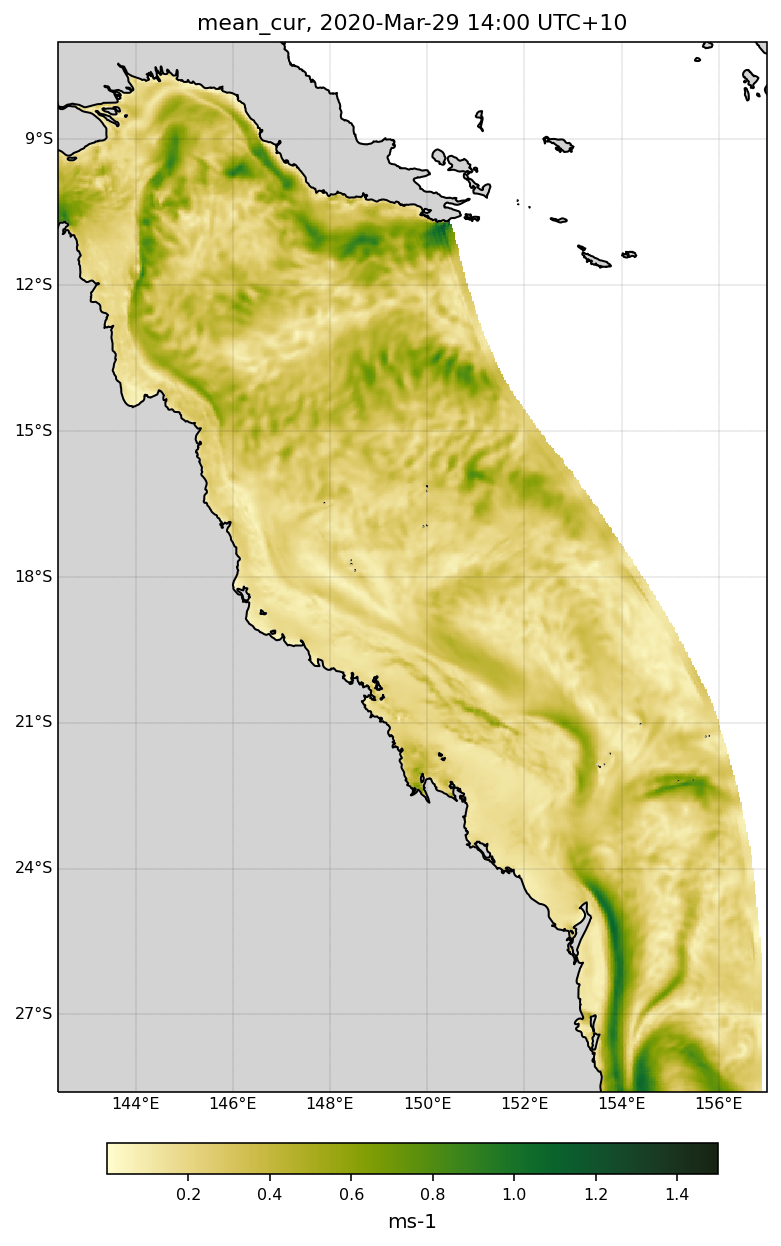

<Figure size 432x288 with 0 Axes>

In [145]:
# Get data
data = ncdata[selectedVariable][selectedTimeIndex, selectedDepthIndex, :,:]

# Defining the figure
fig = plt.figure(figsize=size, facecolor='w', edgecolor='k')

# Axes with cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree())
# and extent
ax.set_extent([142.4, 157, -7, -28.6], ccrs.PlateCarree())

# Ok now the map
cf = plt.pcolormesh(lon, lat, data, cmap=color, shading='auto',
                    vmin = curlvl[0], vmax = curlvl[1],
                    transform=ccrs.PlateCarree())

# Color bar
cbar = fig.colorbar(cf, ax=ax, fraction=0.027, pad=0.045, 
                    orientation="horizontal")
cbar.set_label(ncdata[selectedVariable].units, rotation=0, 
               labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)

# Title
dtime = netCDF4.num2date(time_var[selectedTimeIndex],time_var.units)
daystr = dtime.strftime('%Y-%b-%d %H:%M')
plt.title(ncdata[selectedVariable].long_name+', %s UTC+10' % (daystr), 
          fontsize=11);

# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8} 

# Add map features with Cartopy 
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
                                            edgecolor='face', 
                                            facecolor='lightgray'))
ax.coastlines(linewidth=1)

plt.tight_layout()
plt.show()
fig.clear()
plt.close(fig)
plt.clf()

### Adding the quiver plot on top

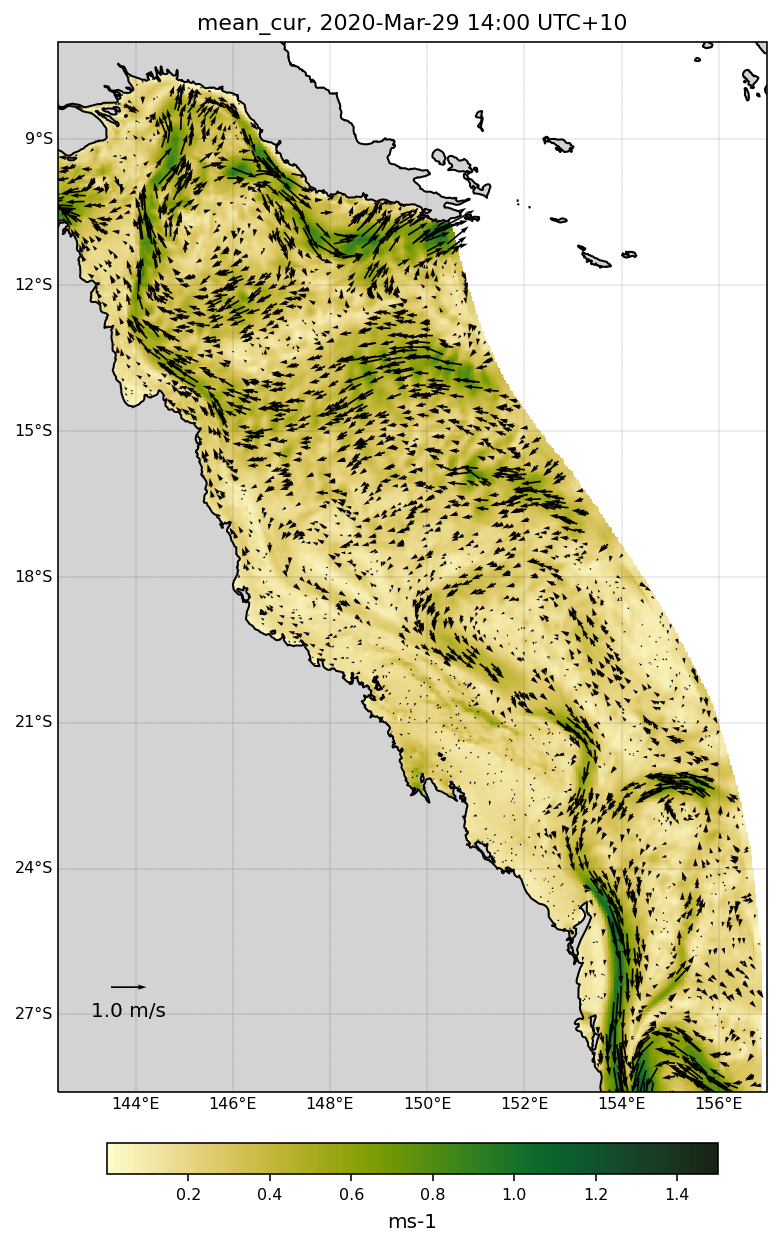

<Figure size 432x288 with 0 Axes>

In [146]:
# Get data
data = ncdata[selectedVariable][selectedTimeIndex, selectedDepthIndex, :,:]

# Defining the figure
fig = plt.figure(figsize=size, facecolor='w', edgecolor='k')

# Axes with cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree())
# and extent
ax.set_extent([142.4, 157, -7, -28.6], ccrs.PlateCarree())

# Ok now the map
cf = plt.pcolormesh(lon, lat, data, cmap=color, shading='auto',
                    vmin = curlvl[0], vmax = curlvl[1],
                    transform=ccrs.PlateCarree())

# For the quiver plot we will first need to create a mesh.
# We used numpy mesgrid function for this
loni, lati = np.meshgrid(lon, lat)

# The direction of the current is given by the u and v parameters in 
# the netcdf file
u = ncdata['u'][selectedTimeIndex, selectedDepthIndex, :,:]
v = ncdata['v'][selectedTimeIndex, selectedDepthIndex, :,:]

# Find non nans velocity points
# data2 = np.copy(data)
# data2[np.isnan(data2)] = 1000

# We look for the points in the dataset inside our specified range
# we basically don't take nan points
ind = np.where(np.logical_and(data.flatten()>curlvl[0],
                              data.flatten()<curlvl[1]))[0]
np.random.shuffle(ind)

# We then rnadomly chose a number of points, we don't take all of the
# points otherwise the figure will be unreadable
Nvec = int(len(ind) / vecsample)
idv = ind[:Nvec]

# We have everything we need we can now use the quiver function
Q = plt.quiver(loni.flatten()[idv],
               lati.flatten()[idv],
               u.flatten()[idv],
               v.flatten()[idv],
               transform=ccrs.PlateCarree(), 
               scale=20)

# We will add a vector scale as a legend to our plot 
maxstr = '%3.1f m/s' % veclenght
qk = plt.quiverkey(Q,0.1,0.1,veclenght,maxstr,labelpos='S')
        
        
# Color bar
cbar = fig.colorbar(cf, ax=ax, fraction=0.027, pad=0.045, 
                    orientation="horizontal")
cbar.set_label(ncdata[selectedVariable].units, rotation=0, 
               labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)

# Title
dtime = netCDF4.num2date(time_var[selectedTimeIndex],
                         time_var.units)
daystr = dtime.strftime('%Y-%b-%d %H:%M')
plt.title(ncdata[selectedVariable].long_name+', %s UTC+10' % (daystr), 
          fontsize=11);

# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8} 

# Add map features with Cartopy 
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
                                            edgecolor='face', 
                                            facecolor='lightgray'))
ax.coastlines(linewidth=1)

plt.tight_layout()
plt.show()
fig.clear()
plt.close(fig)
plt.clf()

## Build a function to automatise the process

Now we will use the function **eReefs_GBR_Model** below to plot the different variables at specific time step and depth.

We want the function to be reusable for:
- different depth and time intervals
- different variable names (temperature, salinity, ...)
- variable colorbar and figure size
- possibility to zoom to a specific region
- plotting quiver plots when current maps are visualised 
- showing and saving figures


In [153]:
def eReefs_map(ncdata, tstep, depth, dataname, datalvl, color, size, 
               fname, vecsample, veclenght, vecscale, zoom=None, 
               show=False, vecPlot=False, save=False):
    '''
    This function plots for a specified time index and depth the value of a variable from the eReefs netCDF
    file available on the AIMS OpenDAP server.
    
    args:
    
    - ncdata: netcdf dataset
    - tstep: specified time index
    - depth: specified depth layer
    - dataname: specified variable name 
    - datalvl: range of the variable values specified as a list [min,max] 
    - color: colormap to use for the plot (here one can use the cmocean library: https://matplotlib.org/cmocean/#installation)
    - size: figure size  
    - fname: figure name when saved on disk, it is worth noting that the specified time index and depth layer will be automatically added
    - vecsample: sampling on velocity arrows to plot on the maps when velocity verctor are used
    - veclenght: lenght of the reference vector (in m/s)
    - vecscale: vector scaling
    - zoom: study site to plot lower left and upper right corner [lon0,lat0, lon1, lat1]
    - show: set to True when the map is shown in the jupyter environment directly 
    - vecPlot: set to True when the current flow vector are plotted
    - save: set to True to save figure on disk
    '''
    
    # Get data
    data = ncdata[dataname][tstep, depth, :,:]
    
    fig = plt.figure(figsize=size, facecolor='w', edgecolor='k')

    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([142.4, 157, -7, -28.6], ccrs.PlateCarree())
    
    # Starting with the spatial domain
    lat = ncdata['latitude'][:]
    lon = ncdata['longitude'][:]
    cf = plt.pcolormesh(lon, lat, data, cmap=color, shading='auto',
                    vmin = datalvl[0], vmax = datalvl[1],
                    transform=ccrs.PlateCarree())

    # Plot velocity arrows 
    if vecPlot:
        loni, lati = np.meshgrid(lon, lat)
        u = ncdata['u'][tstep, depth, :,:]
        v = ncdata['v'][tstep, depth, :,:]
        
        if zoom is not None:
            # find non zeros velocity points
            dataid = np.where(np.logical_and(data.flatten()>datalvl[0],
                                          data.flatten()<datalvl[1]))[0]
            
            lonid = np.where(np.logical_and(loni.flatten()>zoom[0],
                                          loni.flatten()<zoom[2]))[0]
            
            latid = np.where(np.logical_and(lati.flatten()>zoom[1],
                                          lati.flatten()<zoom[3]))[0]
            
            tmpid = np.intersect1d(lonid, latid)
            ind = np.intersect1d(tmpid, dataid)
        else:
            # find non zeros velocity points
            ind = np.where(np.logical_and(data.flatten()>datalvl[0],
                                          data.flatten()<datalvl[1]))[0]
        np.random.shuffle(ind)
        Nvec = int(len(ind) / vecsample)
        idv = ind[:Nvec]
        Q = plt.quiver(loni.flatten()[idv],
                       lati.flatten()[idv],
                       u.flatten()[idv],
                       v.flatten()[idv],
                       transform=ccrs.PlateCarree(), 
                       scale=vecscale)

        maxstr='%3.1f m/s' % veclenght
        qk = plt.quiverkey(Q,0.1,0.1,veclenght,maxstr,labelpos='S')


    # Color bar
    cbar = fig.colorbar(cf, ax=ax, fraction=0.027, pad=0.045, 
                        orientation="horizontal")
    cbar.set_label(ncdata[dataname].units, rotation=0, 
                   labelpad=5, fontsize=10)
    cbar.ax.tick_params(labelsize=8)
    

    # Title
    dtime = netCDF4.num2date(ncdata['time'][tstep],ncdata['time'].units)
    daystr = dtime.strftime('%Y-%b-%d %H:%M')
    plt.title(ncdata[dataname].long_name+', %s UTC+10' % (daystr), 
              fontsize=11);

    # Plot lat/lon grid 
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.1, color='k', alpha=1, 
                      linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8} 
    
    # Add map features
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
                                                edgecolor='face', 
                                                facecolor='lightgray'))
    ax.coastlines(linewidth=1)

    if zoom is not None:
        plt.xlim(zoom[0],zoom[2])
        plt.ylim(zoom[1],zoom[3])
    
    if show:
        if save:
            plt.savefig(f"{fname}_time{tstep:04}_zc{depth:04}.png",dpi=300, 
                    bbox_inches='tight')
        plt.tight_layout()
        plt.show()
    else:
        plt.savefig(f"{fname}_time{tstep:04}_zc{depth:04}.png",dpi=300, 
                bbox_inches='tight')

    fig.clear()
    plt.close(fig)
    plt.clf()
    
    return

Let's use the function. First we will check for a specific time and a depth each variable range:

In [148]:
print(' ')
print('Temperature range: ')
print(np.nanmin(ncdata['temp'][selectedTimeIndex, selectedDepthIndex, :,:]),
      np.nanmax(ncdata['temp'][selectedTimeIndex, selectedDepthIndex, :,:]))

print(' ')
print('Salinity range: ')
print(np.nanmin(ncdata['salt'][selectedTimeIndex, selectedDepthIndex, :,:]),
      np.nanmax(ncdata['salt'][selectedTimeIndex, selectedDepthIndex, :,:]))

 
Temperature range: 
24.66653 31.789503
 
Salinity range: 
0.036854204 36.043182


We will plot the mean current like this:

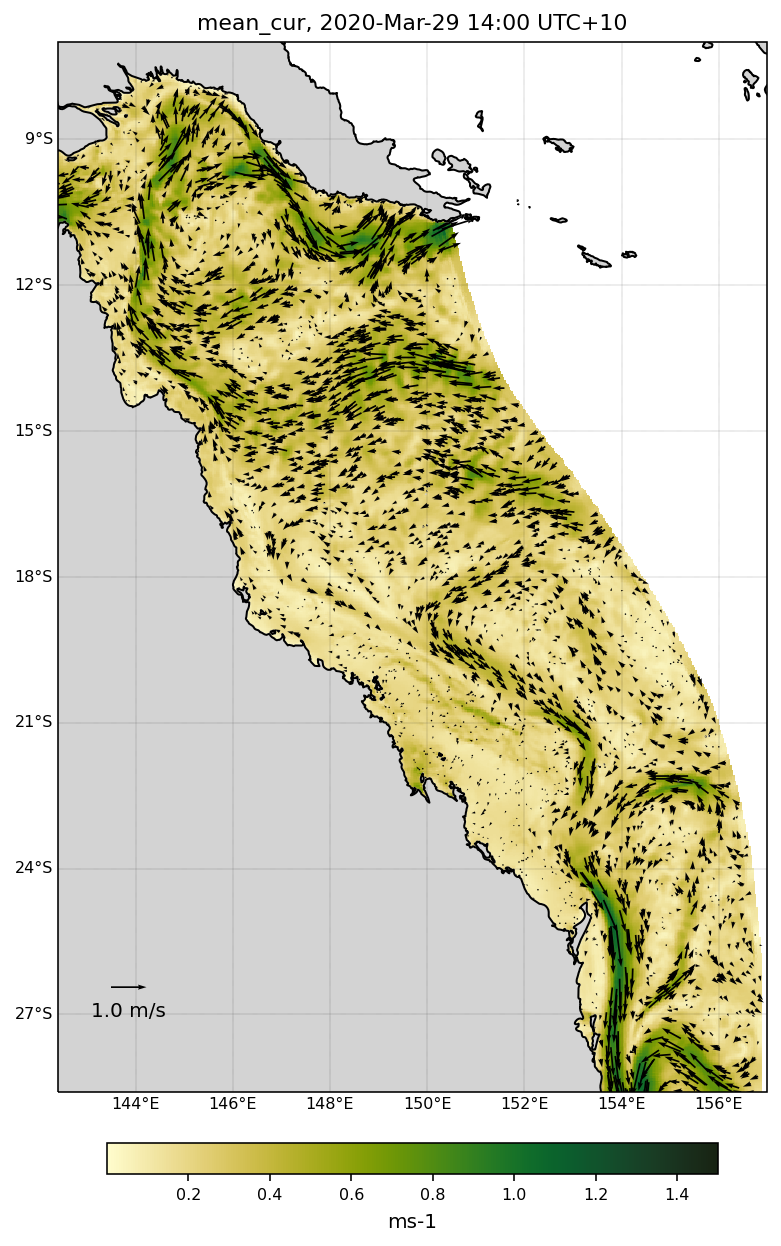

<Figure size 432x288 with 0 Axes>

In [149]:
selectedVariable = 'mean_cur' 


# Vector field mapping information
veclenght = 1.
vecsample = 50
vecscale = 20

# Figure size
size = (9, 10)

# Used color
color = cmocean.cm.speed

# Variable range for the colorscale
curlvl = [0.001,1.5]

# Saved file name
fname = 'GBRcurrent'

# Region to plot
zoom = None

# We now call the function
eReefs_map(nc_data, selectedTimeIndex, selectedDepthIndex, 
           selectedVariable, curlvl, color, size, fname, 
           vecsample, veclenght, vecscale, zoom, 
           show=True, vecPlot=True, save=False)

### Checking the zooming function

<ipython-input-153-46dda7b82468>:119: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


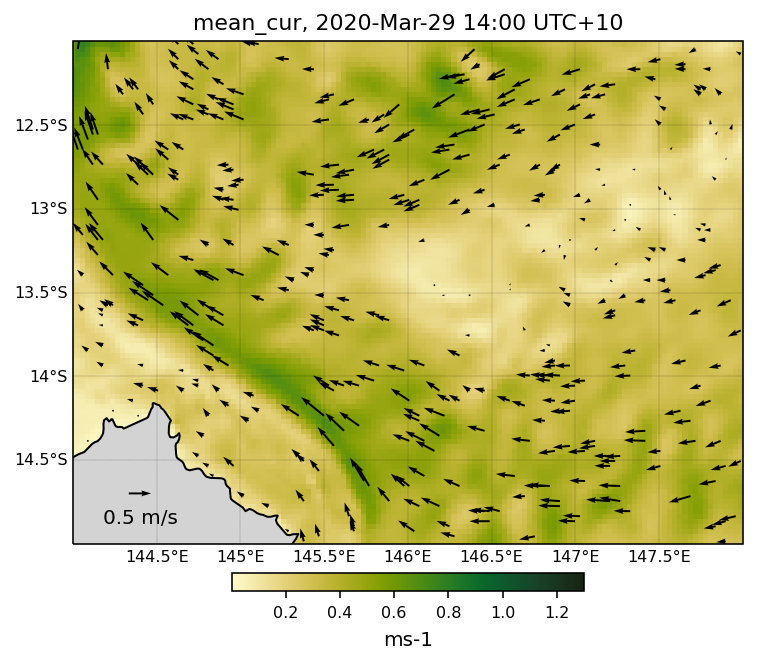

<Figure size 432x288 with 0 Axes>

In [154]:
selectedVariable = 'mean_cur' 


# Vector field mapping information
veclenght = 0.5
vecsample = 30
vecscale = 15

# Figure size
size = (6, 6)

# Used color
color = cmocean.cm.speed

# Variable range for the colorscale
curlvl = [0.001,1.3]

# Saved file name
fname = 'GBRcurrent'

# Region to plot
zoom = [144,-15,148,-12]

# We now call the function
eReefs_map(nc_data, selectedTimeIndex, selectedDepthIndex, 
           selectedVariable, curlvl, color, size, fname, 
           vecsample, veclenght, vecscale, zoom, 
           show=True, vecPlot=True, save=False)

For the salinity dataset...

<ipython-input-147-5bef17315fd3>:118: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


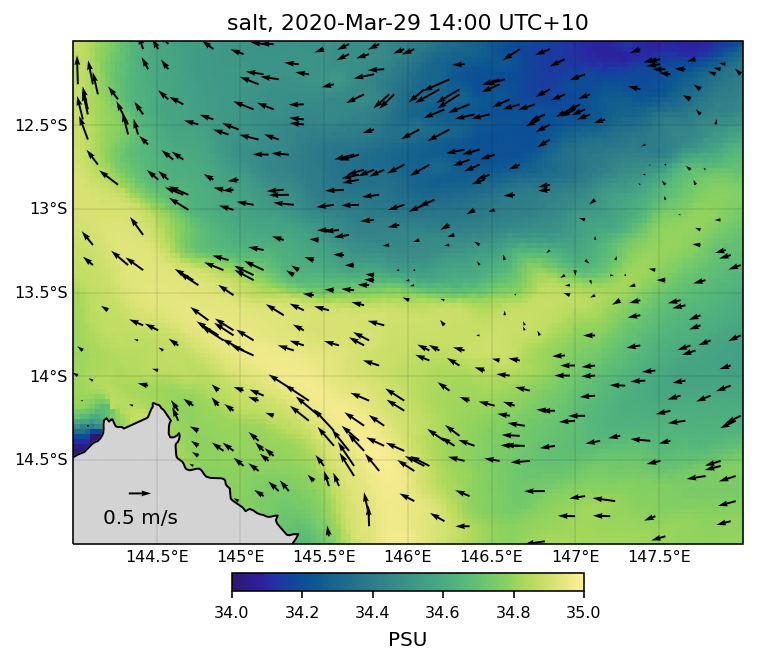

<Figure size 432x288 with 0 Axes>

In [151]:
selectedVariable = 'salt'

# Used color
color = cmocean.cm.haline

# Variable range for the colorscale
saltlvl = [34,35]

# Saved file name
fname = 'GBRsalinity'

# We now call the function
eReefs_map(nc_data, selectedTimeIndex, selectedDepthIndex, 
           selectedVariable, saltlvl, color, size, fname, 
           vecsample, veclenght, vecscale, zoom, 
           show=True, vecPlot=True, save=False)

For the tempreature dataset...

<ipython-input-147-5bef17315fd3>:118: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


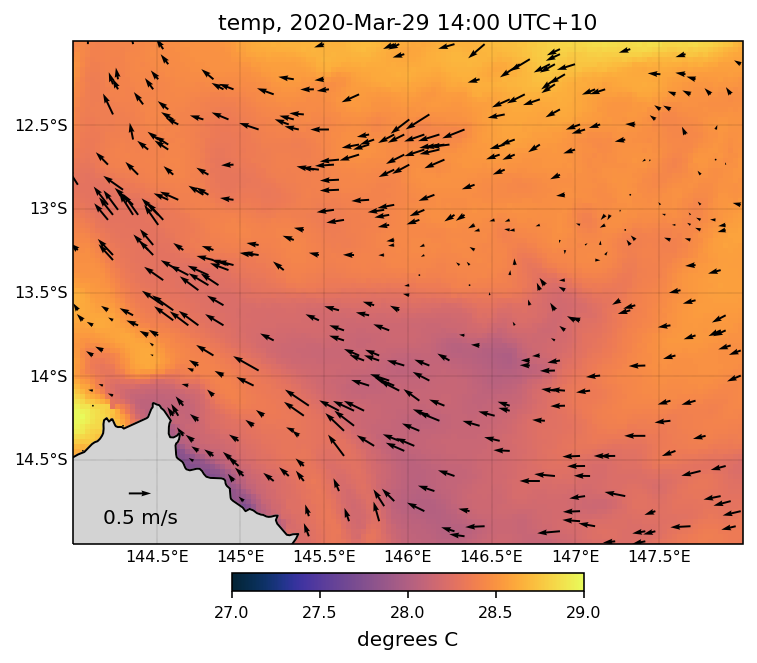

<Figure size 432x288 with 0 Axes>

In [152]:
selectedVariable = 'temp'

# Used color
color = cmocean.cm.thermal

# Variable range for the colorscale
templvl = [27,29]

# Saved file name
fname = 'GBRtemperature'

# We now call the function
eReefs_map(nc_data, selectedTimeIndex, selectedDepthIndex, 
           selectedVariable, templvl, color, size, fname, 
           vecsample, veclenght, vecscale, zoom, 
           show=True, vecPlot=True, save=False)